In [13]:
using Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate();

In [14]:
import ForwardDiff as FD
using LinearAlgebra
using Plots

include(joinpath(@__DIR__,"helpers/DEL_dynamics.jl"))
include(joinpath(@__DIR__,"helpers/quaternions.jl"))

quat2rot (generic function with 1 method)

### Simulation paramters

In [15]:
h = 0.01 # 100 Hz
T_final = 5 # final time
T_hist = Array(0:h:T_final)
N = length(T_hist)

# model parameters
params_link1 = (m=1.0, J=Diagonal([0.1, 1.0, 1.0]), g=0) # rigidbody parameters

m1 = params_link1.m
J1 = params_link1.J

# random initial orientation
q0 = [1, 0, 0, 0]
# q0 = normalize(rand(4))
x0 = [0, 0, 0]
v0 = [0, 0, 0]
ω0 = [0, 0, 2 * 3.14159]

# initial conditions
link1_state0 = [x0; q0] # initial state of the rigidbody
# link1_state1 = [x0; q0] # initial state of the rigidbody

link1_vel0 = [v0; ω0] # initial velocity of the rigidbody
link1_momentum0 = vel2mom(link1_vel0, params_link1) # initial momentum of the rigidbody

# forcing terms
forces = [0, 0, 0]
torques = [0, 0, -10]
no_forcing = zeros(6) # no external forces

forcing = [forces; torques]

forcing_matrix = zeros(6, N)

# forcing_matrix[:, 5:6] .= forcing

# integrate
state_hist = zeros(7, N)
momentum_hist = zeros(6, N)

state_hist[:, 1] = link1_state0
# state_hist[:, 2] = link1_state0
momentum_hist[:, 1] = link1_momentum0

for i in 2:N
  state_hist[:, i], momentum_hist[:, i] = integrator_step(
    hcat(momentum_hist[:, i-1]),
    hcat(state_hist[:, i-1]),
    hcat(forcing_matrix[:, i-1]),
    hcat(forcing_matrix[:, i]),
    [params_link1],
    h, 
    max_iters=50)
end

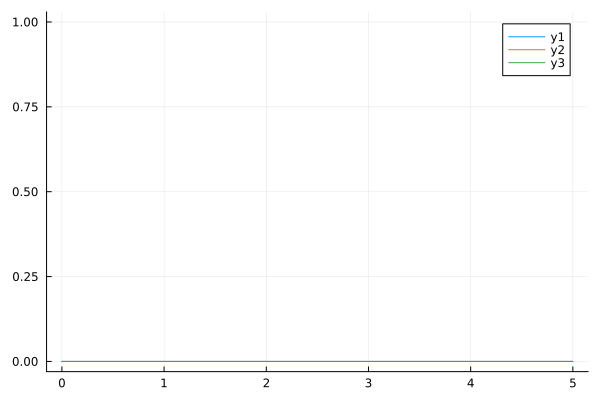

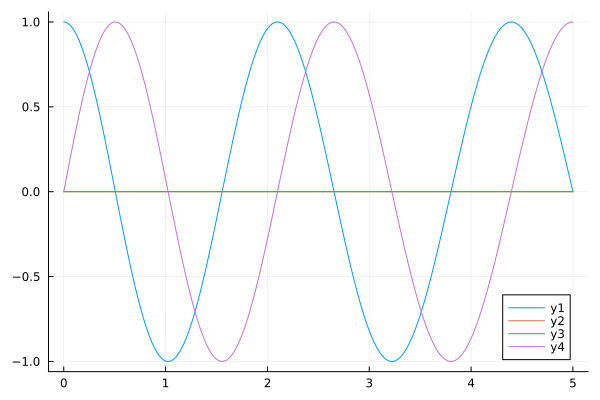

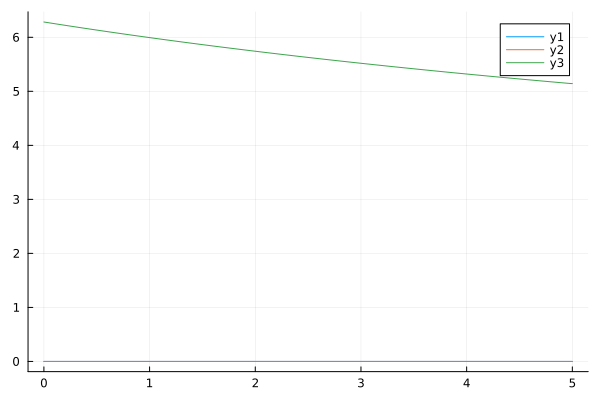

In [16]:
display(plot(T_hist, state_hist[1:3,:]'))

display(plot(T_hist, state_hist[4:7,:]'))

display(plot(T_hist, momentum_hist[4:6,:]'))

### Visualization

In [9]:
using MeshCat, GeometryBasics, CoordinateTransformations, Rotations

In [18]:
vis = Visualizer()
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8701, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8701), "127.0.0.1", "8701", nothing, Sockets.TCPServer(RawFD(32) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00007fb9ccf78740, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (8, 140435947809344, 140435935445360)))))

In [20]:
delete!(vis)

green_material = MeshPhongMaterial(color=RGBA(0, 1, 0, 0.8))
cylinder1 = Cylinder(Point(-0.5, 0, 0), Point(0.5, 0, 0), 0.1)
setobject!(vis["cylinder1"], cylinder1, green_material)


for k = 1:N
    # set position and attitude
    position1 = Translation(state_hist[1:3, k]...)
    attitude1 = LinearMap(UnitQuaternion(state_hist[4:7, k]))

    settransform!(vis["cylinder1"], compose(position1, attitude1))
    sleep(h)
end
